C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:160: UserWarning: [06:56:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "depth", "iterations" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:160: UserWarning: [06:56:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "depth", "iterations" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classificatio

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1216
           1       0.84      0.84      0.84      1245
           2       0.87      0.86      0.86      1215
           3       0.94      0.72      0.82      1074

   micro avg       0.88      0.82      0.85      4750
   macro avg       0.89      0.82      0.85      4750
weighted avg       0.89      0.82      0.85      4750
 samples avg       0.56      0.53      0.54      4750



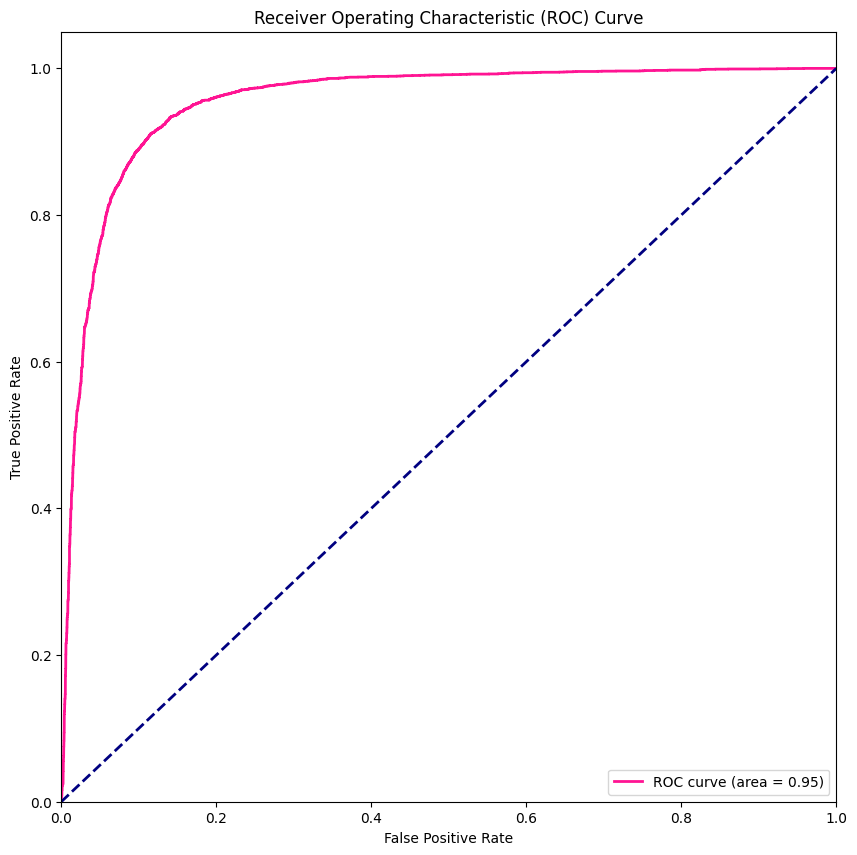

In [2]:
import pandas as pd
import numpy as np 
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb   
from sklearn.metrics import classification_report
import joblib
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression 
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
# from catboost import CatBoostClassifier

df = pd.read_csv('StockLogistic.csv')
# df.drop(columns=['Unnamed: 0','Month'], inplace=True) 
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.drop(columns=['Unnamed: 0','Unnamed: 0.1','Month','Year'], inplace=True)

from xgboost import plot_importance


# Create second class with tuned parameters. 
class XBoostTuned:
    def __init__(self, data):
        self.data = data
        # self.date_convert()
        self.split_data()
        self.train_baseline()
        
    def split_data(self):
        tscv = TimeSeriesSplit(n_splits=3)  # Define the number of splits
        
        # Initialize train and test lists
        train_indices = []
        test_indices = []
        
        for train_index, test_index in tscv.split(self.data):
            train_indices.append(train_index)
            test_indices.append(test_index)
        
        # Concatenate train and test data
        train_indices = [idx for split in train_indices for idx in split]
        test_indices = [idx for split in test_indices for idx in split]
        
        self.train = self.data.iloc[train_indices]
        self.test = self.data.iloc[test_indices]
        #Train the model    
    def train_baseline(self):
        target = ['Target','Target1','Target2','Target3']
        features = self.train.drop(columns=target).values
        target = self.train[target].values
        self.model = xgb.XGBClassifier(iterations=100, learning_rate=0.1, depth=3)
        self.model.fit(features, target)
    
    def predict(self, input_data):
        predictions = self.model.predict(input_data)
        return predictions
    
    def evaluate(self):
        target = ['Target','Target1','Target2','Target3']
        test_features = self.test.drop(columns=target).values
        preds = self.predict(test_features)
        actual = self.test[target]
        acc = classification_report(actual, preds)
        return acc
    
    def plot_feature_importance(self):
        plot_importance(self.model.estimators_[0])
        plt.title('Factors influencing stock price hikes')
        plt.show()

    @staticmethod 
    def save_model(model, model_path='stock-increement2.pkl'):
         joblib.dump(model, model_path)


# Example usage:
boost_model = XBoostTuned(df)
boost_model.split_data()
boost_model.train_baseline()
accuracy = boost_model.evaluate()
print(accuracy)
# boost_model.save_model(boost_model.model)

# Plot ROC AUC curve
from sklearn.metrics import roc_curve, auc

# Predict the probabilities of the various models. 
predictions = boost_model.model.predict_proba(boost_model.test.drop(columns=['Target','Target1','Target2','Target3']).values)
true_labels = boost_model.test[['Target','Target1','Target2','Target3']].values

#ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(true_labels[0])):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Average ROC curve 
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
